In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
import tensorflow_probability as tfp

from distributions import Distribution, plot_distribution, plot_distributions, EXPERIMENT_PARAMS, color1, color2

sns.set_context('talk')
%config InlineBackend.figure_format='retina'


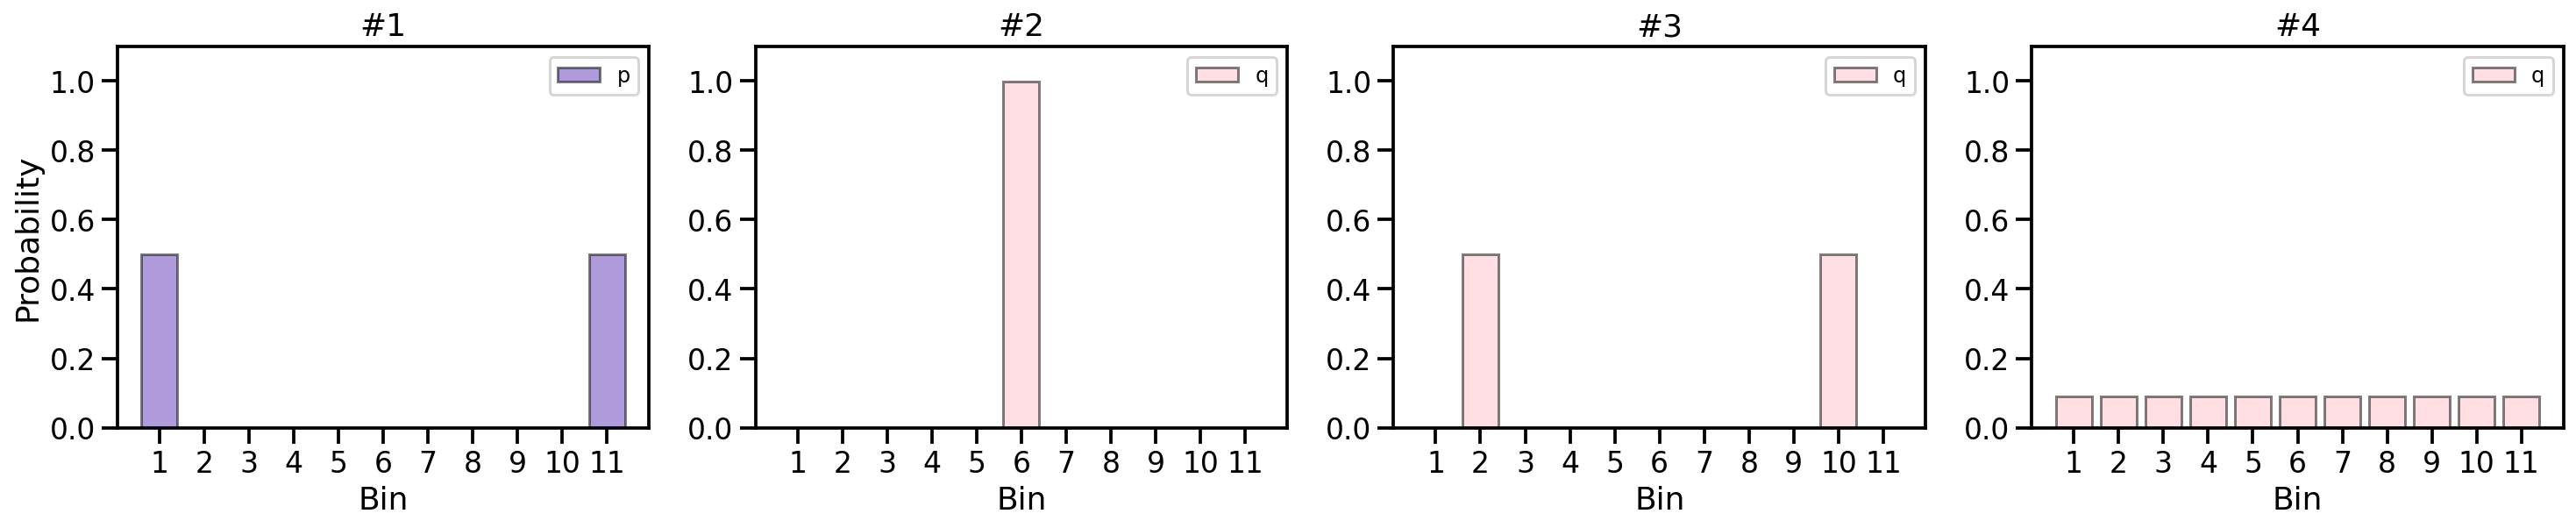

In [25]:
# Ground truth
p1 = Distribution({1: 0.5, 11: 0.5}, eps=EXPERIMENT_PARAMS['eps'])

# Predicted distributions
q1 = Distribution({6: 1}, eps=EXPERIMENT_PARAMS['eps'])
q2 = Distribution({2: 0.5, 10: 0.5}, eps=EXPERIMENT_PARAMS['eps'])
q3 = Distribution({i: 1 / 11 for i in np.arange(1, 12)}, eps=0)

plot_distributions([
    {'p': p1}, {'q': q1}, {'q': q2}, {'q': q3}
])


### Brier Score

In [26]:
def to_cdf(x):
    return np.cumsum(x, axis=-1)


def brier_multi(targets, probs):
    # https://stats.stackexchange.com/questions/403544/how-to-compute-the-brier-score-for-more-than-two-classes
    return np.mean(np.sum((probs - targets)**2, axis=-1))


def brier_full_decomp(targets, probs):
    targets = targets.T 
    probs = probs.T 

    full_reliability_list = []
    full_resolution_list = []
    full_uncertainty_list = []

    for i in range(len(targets)):
        
        targets_cati = targets[i]   
        probs_cati = probs[i]

        df_tmp = pd.DataFrame({'p': targets_cati, 'q': probs_cati})
        df_tmp = df_tmp.assign(qbin=pd.cut(df_tmp.q, bins=np.arange(0,1.01, 0.01)))
        df_tmp_agg = df_tmp.groupby('qbin').agg({'p': ['mean', 'count']}).reset_index()

        # Reliability
        reliability_list = []
        for _, row in df_tmp_agg.iterrows():
            bin_target_mean = row[('p', 'mean')]
            bin_count = row[('p', 'count')]
            qbin_ = row['qbin']

            # Get error for all predictions in this bin
            df_tmp_in_this_bin = df_tmp[df_tmp.qbin == qbin_[0]] 
            reliability_bin = ((df_tmp_in_this_bin.q - bin_target_mean) ** 2).sum() 

            reliability_list.append(reliability_bin)

        reliability = np.sum(reliability_list) / len(targets_cati)
        full_reliability_list.append(reliability)

        # Resolution
        target_mean = df_tmp.p.mean()
        resolution_list = []
        weight_list = []
        for _, row in df_tmp_agg[df_tmp_agg[('p', 'mean')].notnull()].iterrows():
            bin_target_mean = row[('p', 'mean')]
            bin_count = row[('p', 'count')]

            resolution_bin = ((bin_target_mean - target_mean) ** 2)
            
            resolution_list.append(resolution_bin)
            weight_list.append(bin_count)
        
        if len(resolution_list) > 0:
            resolution = np.average(resolution_list, weights=weight_list)
            full_resolution_list.append(resolution)

        # Uncertainty
        uncertainty = targets_cati.mean() * (1 - targets_cati.mean())
        full_uncertainty_list.append(uncertainty)

    return (
        np.sum(full_reliability_list) - np.sum(full_resolution_list) + np.sum(full_uncertainty_list), 
        np.sum(full_reliability_list),
        np.sum(full_resolution_list),
        np.sum(full_uncertainty_list)
    )

### Discrete Ranked Probability Score

In [27]:
def rps(targets, probs):
    targets = to_cdf(targets)
    probs = to_cdf(probs)
    return np.mean((probs - targets)**2, axis=-1).mean()


def rps_full_decomp(targets, probs):
    targets = to_cdf(targets)
    probs = to_cdf(probs)
    num_classes = targets.shape[-1]

    rps_result, reli, reso, unc = [x.mean() for x in brier_full_decomp(targets, probs)]
    return  rps_result / num_classes, reli / num_classes, reso / num_classes, unc / num_classes

### Performance
We can see below that 

In [28]:
p1_samples = p1.sample_ohe(1000)

In [29]:
p1_samples

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [30]:
q_names = ['p1', 'q1', 'q2', 'q3']

baseline_rps_scores = [
    rps(p1_samples, p1.probs),
    rps(p1_samples, q1.probs),
    rps(p1_samples, q2.probs),
    rps(p1_samples, q3.probs)
]

rps_decomp_scores = []
reliability_scores = []
resolution_scores = []
uncertainty_scores = []
for dist in [p1, q1, q2, q3]:

    bs, reli, reso, unc = rps_full_decomp(p1_samples, np.broadcast_to(dist.probs.reshape(1, -1), p1_samples.shape))
    rps_decomp_scores.append(bs)
    reliability_scores.append(reli)
    resolution_scores.append(reso)
    uncertainty_scores.append(unc)

pd.DataFrame({
    'q_name': q_names,
    'rps_baseline_score': baseline_rps_scores,
    'rps_decomposition_score': rps_decomp_scores,
    'reliability': reliability_scores,
    'resolution': resolution_scores,
    'uncertainty': uncertainty_scores 
})


,q_name,rps_baseline_score,rps_decomposition_score,reliability,resolution,uncertainty
0,p1,0.227273,0.227273,0.000178,0.0,0.227095
1,q1,0.454273,0.454273,0.227178,0.0,0.227095
2,q2,0.272707,0.272707,0.045613,0.0,0.227095
3,q3,0.289256,0.289256,0.062162,0.0,0.227095


This worked as expected! 
* The true distribution, `p1`, yielded the lowest rps! 
* The 3rd distribution is second best. 
* And the 2nd distribution is the worst. And our decomposition checks out. 
* However, because we used the _same_ predicted distribution the entire time, our resolution was always going to be 0. 

Let's see how this performs when we do indeed have different underlying predicted distributions. 

### Performance: Multiple predicted distributions

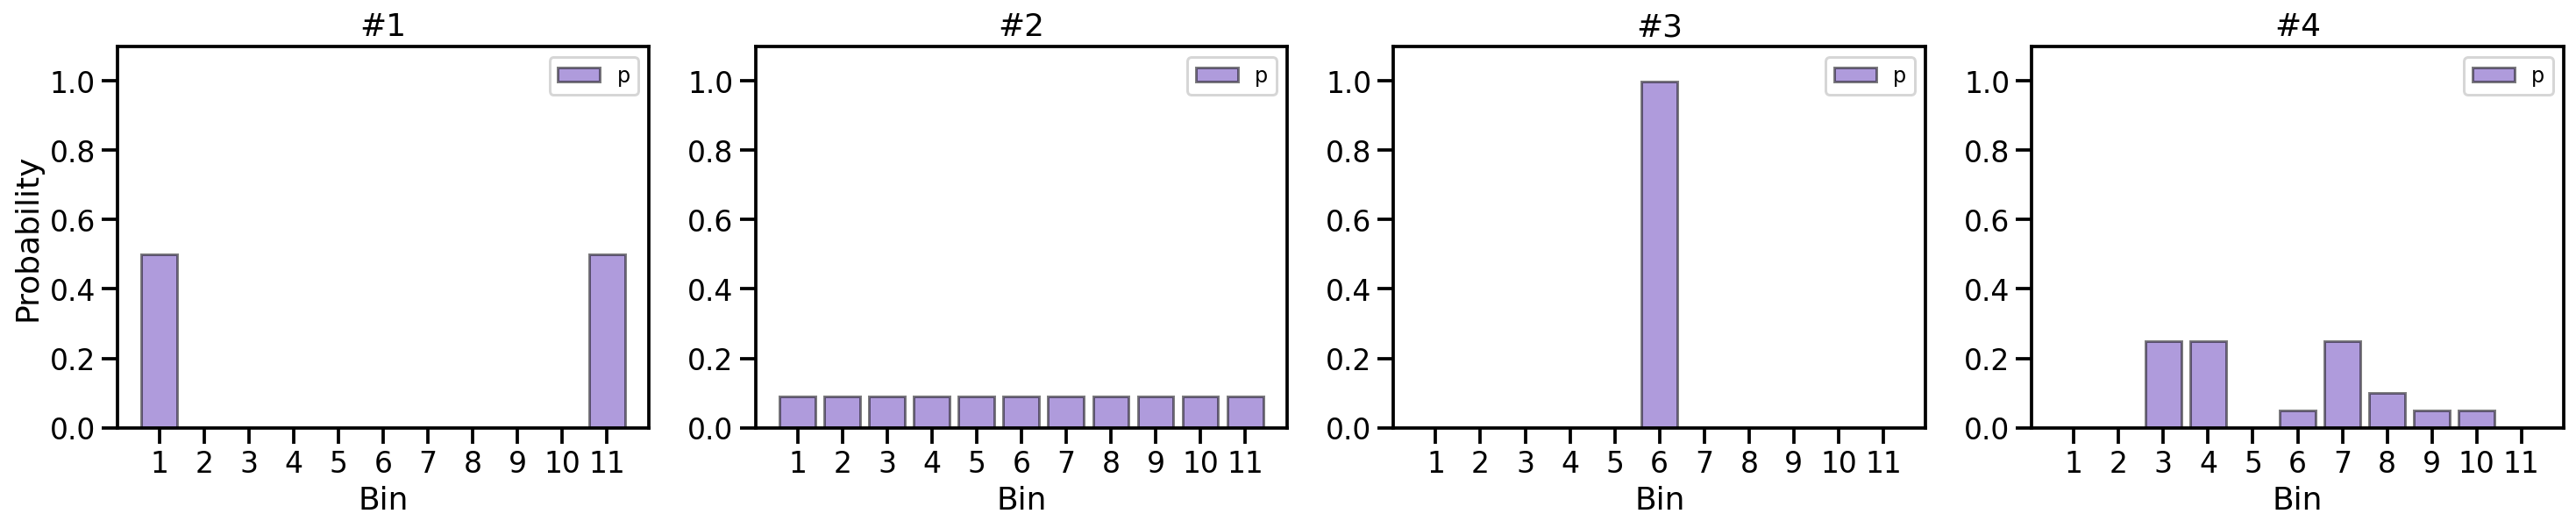

In [31]:
# Create 5 ground truth generating distributions
p1 = Distribution({1: 0.5, 11: 0.5}, eps=EXPERIMENT_PARAMS['eps'])
p2 = Distribution({i: 1 / 11 for i in np.arange(1, 12)}, eps=0)
p3 = Distribution({6: 1}, eps=EXPERIMENT_PARAMS['eps'])
p4 = Distribution({3: 0.25, 4: 0.25, 7: 0.25, 6:0.05, 8: 0.1, 9: 0.05, 10: 0.05}, eps=EXPERIMENT_PARAMS['eps'])

plot_distributions([
    {'p': p1}, {'p': p2}, {'p': p3}, {'p': p4}
])

In [32]:
p1_samples = p1.sample_ohe(1000)
p2_samples = p2.sample_ohe(1000)
p3_samples = p3.sample_ohe(1000)
p4_samples = p4.sample_ohe(1000)

### Our predicted distributions match the true ground truth distributions

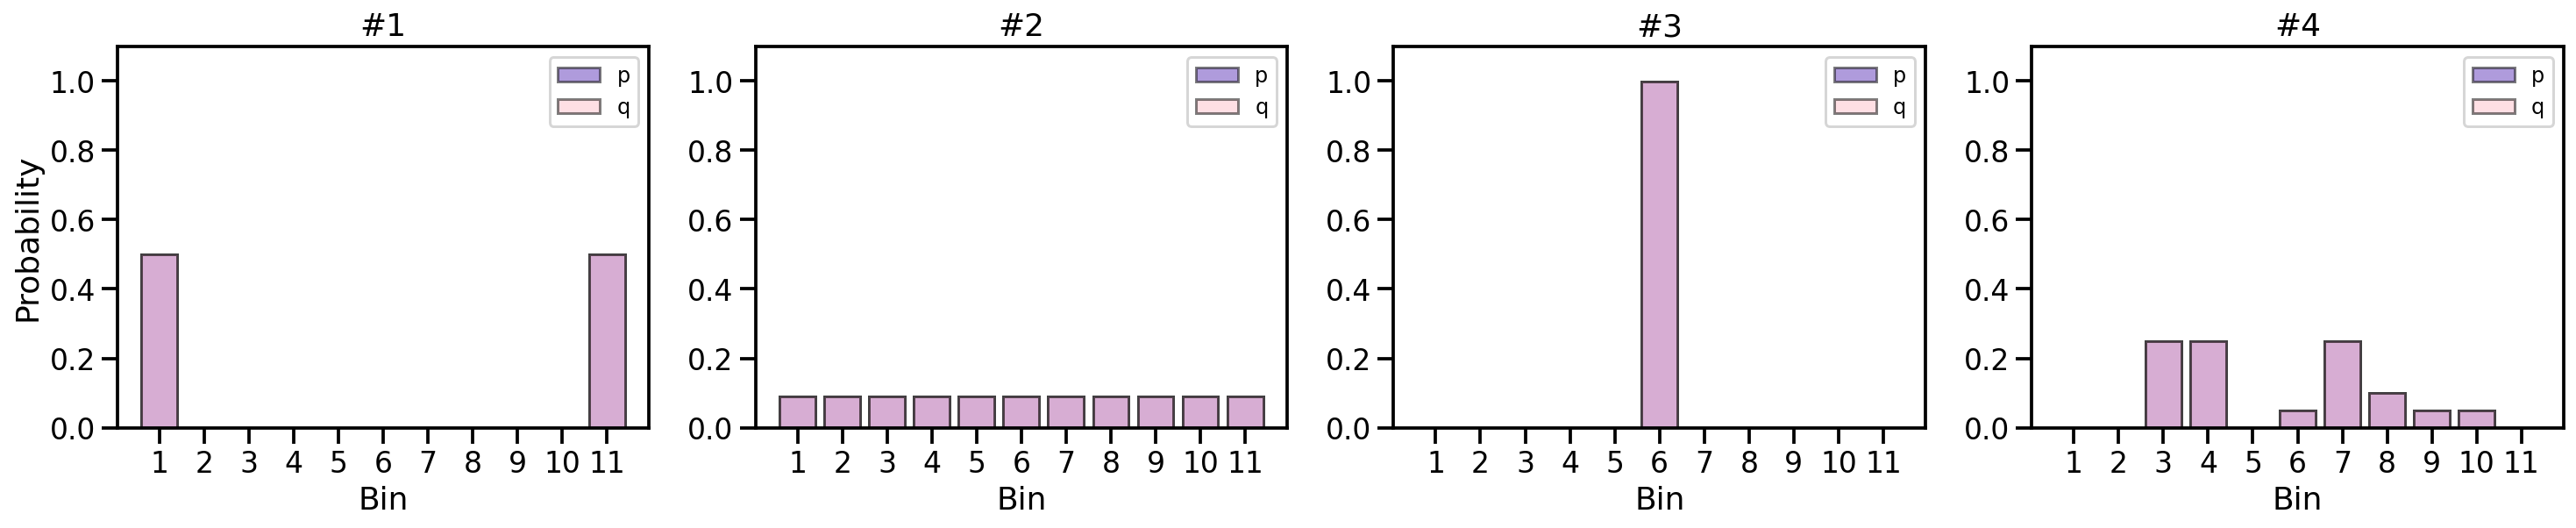

In [33]:
q1_probs = np.broadcast_to(p1.probs.reshape(1, -1), p1_samples.shape)
q2_probs = np.broadcast_to(p2.probs.reshape(1, -1), p2_samples.shape)
q3_probs = np.broadcast_to(p3.probs.reshape(1, -1), p3_samples.shape)
q4_probs = np.broadcast_to(p4.probs.reshape(1, -1), p4_samples.shape)

plot_distributions([
    {'p': p1, 'q': p1}, {'p': p2, 'q': p2}, {'p': p3, 'q': p3}, {'p': p4, 'q': p4}
])



In [34]:
p_samples = np.vstack([p1_samples, p2_samples, p3_samples, p4_samples])
q_probs = np.vstack([q1_probs, q2_probs, q3_probs, q4_probs])

In [35]:
baseline_rps_score = rps(p_samples, q_probs)
bs, reli, reso, unc = rps_full_decomp(p_samples, q_probs)

pd.DataFrame({
    'rps_baseline_score': [baseline_rps_score],
    'rps_decomposition_score': [bs],
    'reliability': [reli],
    'resolution': [reso],
    'uncertainty': [unc] 
})


,rps_baseline_score,rps_decomposition_score,reliability,resolution,uncertainty
0,0.125684,0.125684,0.0001,0.035981,0.161565


In [37]:
p_samples

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [38]:
def _one_hot_encode_targets(probs, num_classes, num_samples):
    assert len(probs) == num_classes
    target_counts = np.random.multinomial(num_samples, probs)
    targets = []
    for i, x in enumerate(target_counts):
        targets.extend([i] * x)
    ohe_targets = keras.utils.to_categorical(targets, num_classes=num_classes)
    return ohe_targets


ground_truth1 = np.array([1 / 2] + [0] * 9 + [1 / 2])
ground_truth2 = np.array([1 / 11] * 11)
ground_truth3 = np.array([0] * 5 + [1] + [0] * 5)
ground_truth4 = np.array([0, 0, 0.25, 0.25, 0, 0.05, 0.25, 0.1, 0.05, 0.05, 0])

NUM_CLASSES = 11
NUM_SAMPLES = 1000

targets1 = _one_hot_encode_targets(ground_truth1, NUM_CLASSES, NUM_SAMPLES)
targets2 = _one_hot_encode_targets(ground_truth2, NUM_CLASSES, NUM_SAMPLES)
targets3 = _one_hot_encode_targets(ground_truth3, NUM_CLASSES, NUM_SAMPLES)
targets4 = _one_hot_encode_targets(ground_truth4, NUM_CLASSES, NUM_SAMPLES)

prediction1 = np.broadcast_to(ground_truth1.reshape(1, -1), targets1.shape)
prediction2 = np.broadcast_to(ground_truth2.reshape(1, -1), targets2.shape)
prediction3 = np.broadcast_to(ground_truth3.reshape(1, -1), targets3.shape)
prediction4 = np.broadcast_to(ground_truth4.reshape(1, -1), targets4.shape)

In [45]:
targets.sum(axis=0)

array([ 582.,   94.,  367.,  323.,  110., 1140.,  337.,  179.,  129.,
        140.,  599.], dtype=float32)

In [44]:
p_samples.sum(axis=0)

array([ 610.,   68.,  345.,  355.,   77., 1148.,  348.,  186.,  145.,
        147.,  571.], dtype=float32)

In [48]:
q1_probs

array([[4.99500000e-01, 1.11111111e-04, 1.11111111e-04, ...,
        1.11111111e-04, 1.11111111e-04, 4.99500000e-01],
       [4.99500000e-01, 1.11111111e-04, 1.11111111e-04, ...,
        1.11111111e-04, 1.11111111e-04, 4.99500000e-01],
       [4.99500000e-01, 1.11111111e-04, 1.11111111e-04, ...,
        1.11111111e-04, 1.11111111e-04, 4.99500000e-01],
       ...,
       [4.99500000e-01, 1.11111111e-04, 1.11111111e-04, ...,
        1.11111111e-04, 1.11111111e-04, 4.99500000e-01],
       [4.99500000e-01, 1.11111111e-04, 1.11111111e-04, ...,
        1.11111111e-04, 1.11111111e-04, 4.99500000e-01],
       [4.99500000e-01, 1.11111111e-04, 1.11111111e-04, ...,
        1.11111111e-04, 1.11111111e-04, 4.99500000e-01]])

In [46]:
q_probs.sum(axis=0)

array([ 590.75909091,   91.37020202,  340.97734488,  340.97734488,
         91.37020202, 1139.87734488,  340.97734488,  190.97734488,
        140.97734488,  140.97734488,  590.75909091])

In [47]:
predictions.sum(axis=0)

array([ 590.90909091,   90.90909091,  340.90909091,  340.90909091,
         90.90909091, 1140.90909091,  340.90909091,  190.90909091,
        140.90909091,  140.90909091,  590.90909091])

In [41]:
targets = np.vstack([targets1, targets2, targets3, targets4])
predictions = np.vstack([prediction1, prediction2, prediction3, prediction4])
score = rps(targets, predictions).mean()
(decomp_score, reli, reso, unc) = rps_full_decomp(targets, predictions)


pd.DataFrame({
    'rps_baseline_score': [score],
    'rps_decomposition_score': [decomp_score],
    'reliability': [reli],
    'resolution': [reso],
    'uncertainty': [unc] 
})



,rps_baseline_score,rps_decomposition_score,reliability,resolution,uncertainty
0,0.12607,0.12901,0.00003,0.033076,0.162056


### Make predictions a bit worse

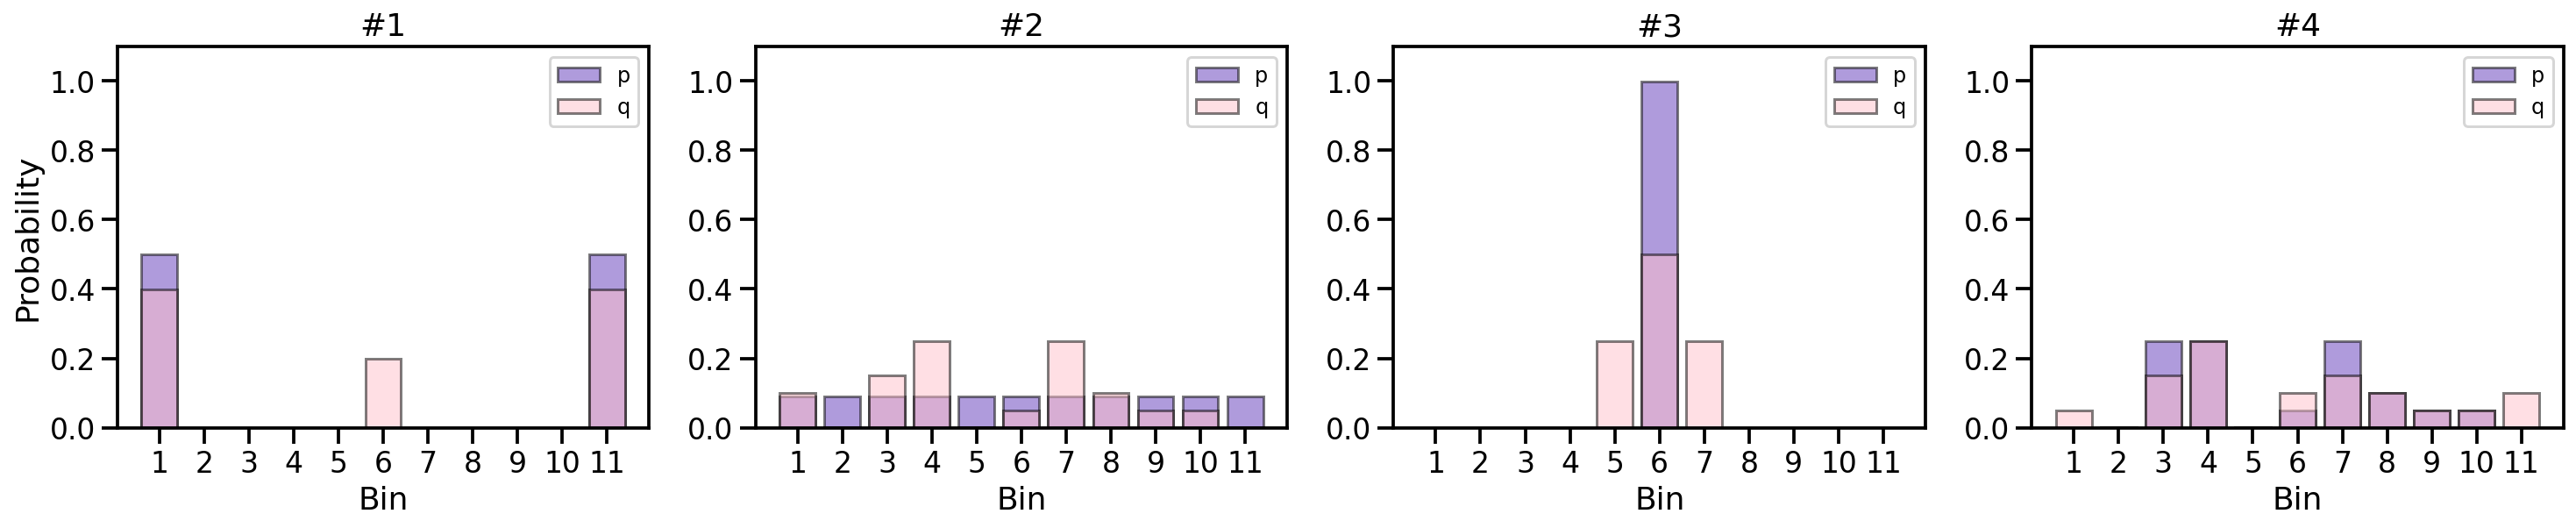

In [73]:
q1 = Distribution({1: 0.4, 6: 0.2,11: 0.4}, eps=EXPERIMENT_PARAMS['eps'])
q2 = Distribution({1: 0.1, 3: 0.15, 4: 0.25, 7: 0.25, 6:0.05, 8: 0.1, 9: 0.05, 10: 0.05}, eps=EXPERIMENT_PARAMS['eps'])
q3 = Distribution({5: 0.25, 6: 0.5, 7: 0.25}, eps=EXPERIMENT_PARAMS['eps'])
q4 = Distribution({1: 0.05, 3: 0.15, 4: 0.25, 7: 0.15, 6:0.1, 8: 0.1, 9: 0.05, 10: 0.05, 11: 0.1}, eps=EXPERIMENT_PARAMS['eps'])

plot_distributions([
    {'p': p1, 'q': q1}, {'p': p2, 'q': q2}, {'p': p3, 'q': q3}, {'p': p4, 'q': q4}
])

In [74]:
# Our predicted distributions match the true ground truth distributions
q1_probs = np.broadcast_to(q1.probs.reshape(1, -1), p1_samples.shape)
q2_probs = np.broadcast_to(q2.probs.reshape(1, -1), p2_samples.shape)
q3_probs = np.broadcast_to(q3.probs.reshape(1, -1), p3_samples.shape)
q4_probs = np.broadcast_to(q4.probs.reshape(1, -1), p4_samples.shape)

q_probs = np.vstack([q1_probs, q2_probs, q3_probs, q4_probs])

In [75]:
baseline_rps_score = rps(p_samples, q_probs)
bs, reli, reso, unc = rps_full_decomp(p_samples, q_probs)

pd.DataFrame({
    'rps_baseline_score': [baseline_rps_score],
    'rps_decomposition_score': [bs],
    'reliability': [reli],
    'resolution': [reso],
    'uncertainty': [unc] 
})


,rps_baseline_score,rps_decomposition_score,reliability,resolution,uncertainty
0,0.135282,0.135283,0.009074,0.036154,0.162363


### Make Predictions much worse

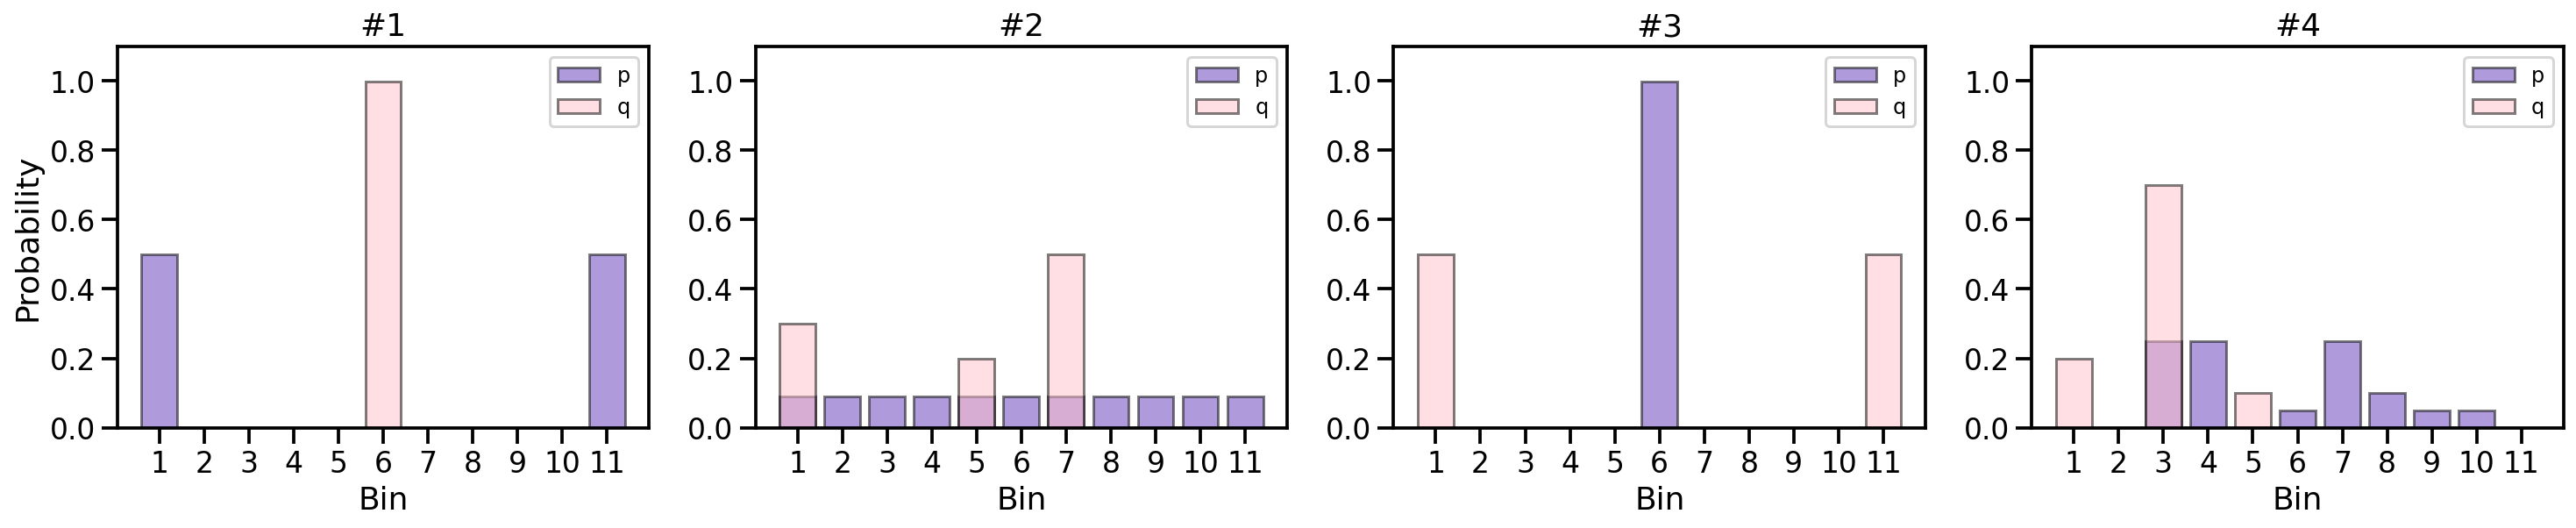

In [60]:
q1 = Distribution({6: 1}, eps=EXPERIMENT_PARAMS['eps'])
q2 = Distribution({1: 0.3, 5: 0.2, 7: 0.5}, eps=EXPERIMENT_PARAMS['eps'])
q3 = Distribution({1: 0.5, 11: 0.5}, eps=EXPERIMENT_PARAMS['eps'])
q4 = Distribution({1: 0.2, 3: 0.7, 5: 0.1}, eps=EXPERIMENT_PARAMS['eps'])

plot_distributions([
    {'p': p1, 'q': q1}, {'p': p2, 'q': q2}, {'p': p3, 'q': q3}, {'p': p4, 'q': q4}
])

In [55]:
# Our predicted distributions match the true ground truth distributions
q1_probs = np.broadcast_to(q1.probs.reshape(1, -1), p1_samples.shape)
q2_probs = np.broadcast_to(q2.probs.reshape(1, -1), p2_samples.shape)
q3_probs = np.broadcast_to(q3.probs.reshape(1, -1), p3_samples.shape)
q4_probs = np.broadcast_to(q4.probs.reshape(1, -1), p4_samples.shape)

q_probs = np.vstack([q1_probs, q2_probs, q3_probs, q4_probs])

In [56]:
baseline_rps_score = rps(p_samples, q_probs)
bs, reli, reso, unc = rps_full_decomp(p_samples, q_probs)

pd.DataFrame({
    'rps_baseline_score': [baseline_rps_score],
    'rps_decomposition_score': [bs],
    'reliability': [reli],
    'resolution': [reso],
    'uncertainty': [unc] 
})


,rps_baseline_score,rps_decomposition_score,reliability,resolution,uncertainty
0,0.271903,0.271898,0.134568,0.024329,0.16166


In [57]:
def rps(targets, probs):
    targets = np.cumsum(targets, axis=-1)
    probs = np.cumsum(probs, axis=-1)
    return np.mean((probs - targets)**2, axis=-1).mean()

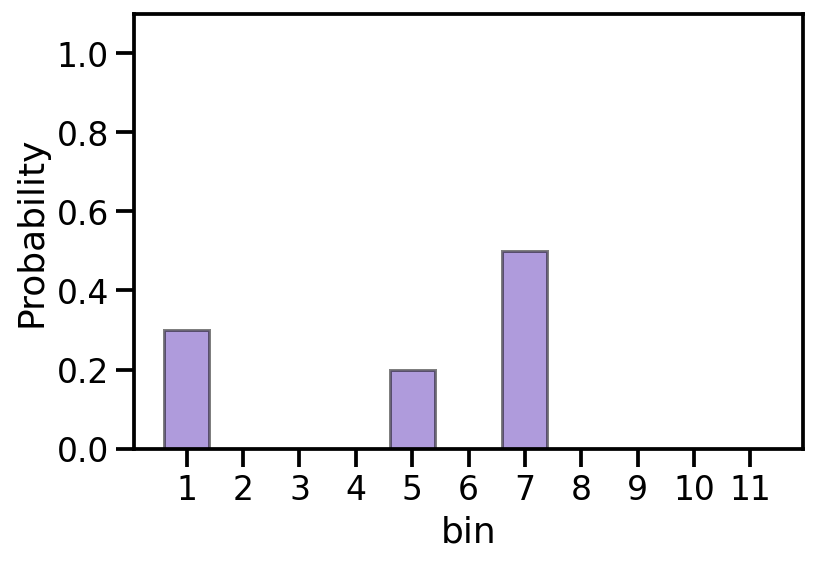

In [61]:
plot_distribution(q2.probs)

In [76]:
targets

NameError: name 'targets' is not defined

In [43]:
np.random.seed(seed=42)

NUM_CLASSES = 11
p = [1/2] + [0]*9 + [1/2]
assert len(p) == NUM_CLASSES
num_samples = 1000

p_samples = np.random.multinomial(num_samples, p)
l = []
for i, x in enumerate(p_samples):
    l.extend([i] * x)
l = keras.utils.to_categorical(l, num_classes=NUM_CLASSES)

predicted_probs = p

rps(l, predicted_probs)

0.22727272727272718

In [38]:
bs, reli, reso, unc = rps_full_decomp(l, np.broadcast_to(predicted_probs, p1_samples.shape))